# Notebook Dedicated to Build the Observables of Interest and Save a Dataset for ML

makes use of the data extracted from real_data_analysis notebook

In [45]:
import numpy as np
import pandas as pd

import seaborn as sn

import glob
import re

In [46]:
def alpha_num_sort(list_route):
    # Función auxiliar para extraer número de la ruta
    def extract_num(route):
        # Busca el primer número en el nombre del archivo
        match = re.search(r'(\d+)', route)
        return int(match.group(1)) if match else -1  # Si no hay número, devuelve -1

    # Ordena la lista usando el número extraído
    return sorted(list_route, key=extract_num)

# Load Data

Load the Data of each fragemented observables

### !! Before Saving the Dataset and reading the Data, define the cuts used to construct the pd.dataframe

In [50]:
imag_dim = (10,10)
en_inf_cut = 2.5
en_sup_cut = 12
posr_cut = 5500
time_res_inf_cut = -1
time_res_sup_cut = 5
nhits_cut = 20

In [48]:
main_dir = 'analysis_out/en_down_2_pt_5_MeV/'
observable_name = ['evtid', 'evtid_bi214', 'energy', 'posr', 'cos_alpha', 'hit_residual']

for var_i in observable_name:
    print(f'preparing observable {var_i}')
    # Empty array fir each observable iteration
    locals()[var_i] = np.array([])

    # file pattern "_"
    pattern = re.compile(rf"{re.escape(var_i)}_(\d+)\.npy$")

    # filtering
    files_all = glob.glob(main_dir + var_i + "_*.npy")
    files_num = [f for f in files_all if pattern.search(f)]

    # alphanumeric order
    flist_var_i = alpha_num_sort(files_num)

    for file_i in flist_var_i:
        arr = np.load(file_i)
        #print(file_i, arr.shape)
        locals()[var_i] = np.append(locals()[var_i], arr)

preparing observable evtid
preparing observable evtid_bi214
preparing observable energy
preparing observable posr
preparing observable cos_alpha
preparing observable hit_residual


In [49]:
energy.shape

(62030,)

# Organize Data by events

1) Find where the evid breaks and extract the data within this interval as a single events;
2) Apply a cut in the number of nhits within the time residual cut;
3) Construct the normalized Δα distribution 10x10 and flat the image;
4) Extract only one energy and radial pos per events;
5) Remove the Bi214 suspected events through evtID index;

## Track Single Event Information

In [51]:
# Empty lists which will contain de non-repeated values of the observables for singles events
energy_ev = []  #flatten list structure
posr_ev = []    #flatten list structure
evtid_ev = []   #flatten list structure
evtid_bi214_ev = np.unique(evtid_bi214).astype(np.uint64)

#per-hit observables
cos_alpha_ev = []  #List filled with np.arrays() where each array correspond to and event
time_residual_ev = [] #List filled with np.arrays() where each array correspond to and event

# ====== Track of single-event values ======

#evID index break list
data_break_i = [0]  #array whose elements are the index from where an event start and end.

N_data = len(evtid)

for i_dx in range(N_data - 1):
    if evtid[i_dx] != evtid[i_dx+1]:
        data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
data_break_i.append(N_data - 1)

N_terms = len(data_break_i)

#Start to save the non-redundant values and separate the time residuals and angles for each event
for i_dx in range(N_terms - 2):
    init_i = data_break_i[i_dx]
    final_i = data_break_i[i_dx+1]

    #energy
    energy_ev_i = energy[init_i : final_i]
    #print(energy_ev_i)
    energy_ev.append(energy_ev_i[0])

    #position
    posr_ev_i = posr[init_i : final_i]
    posr_ev.append(posr_ev_i[0])

    #evtid
    evtid_ev_i = evtid[init_i : final_i]
    evtid_ev.append(evtid_ev_i[0])
    
    #Time residuals
    time_residual_ev_i = hit_residual[init_i : final_i]
    time_residual_ev.append(time_residual_ev_i)
    
    #cos(α)
    cos_alpha_ev_i = cos_alpha[init_i : final_i]
    cos_alpha_ev.append(cos_alpha_ev_i)

energy_ev = np.array(energy_ev)
posr_ev = np.array(posr_ev)
evtid_ev = np.array(evtid_ev).astype(np.uint64)

# ========= Remove the Bi214 candidates entries =========
index_to_remove = np.where((np.in1d(evtid_ev, evtid_bi214_ev)))[0]

energy_ev = np.delete(energy_ev, index_to_remove)
posr_ev = np.delete(posr_ev, index_to_remove)
evtid_ev = np.delete(evtid_ev, index_to_remove)
cos_alpha_ev = [cos_alpha_ev[i] for i in range(len(cos_alpha_ev)) if i not in index_to_remove]
time_residual_ev = [time_residual_ev[i] for i in range(len(time_residual_ev)) if i not in index_to_remove]

# ========== NHits cut ==================
#Save the nhits per event:
nhits_ev = [] #List with the number of hits within the time residual window per event
N_evs = len(cos_alpha_ev)

for i_dx in range(N_evs):
    nhit_ev_i = len(cos_alpha_ev[i_dx])
    nhits_ev.append(nhit_ev_i)
nhits_ev = np.array(nhits_ev)

#Look for where the nhits >= nhitscut
nhits_condition = (nhits_ev >= nhits_cut)

energy_ev = energy_ev[nhits_condition]
posr_ev = posr_ev[nhits_condition]
cos_alpha_ev = [arr for arr, cond in zip(cos_alpha_ev, nhits_condition) if cond]
time_residual_ev = [arr for arr, cond in zip(time_residual_ev, nhits_condition) if cond]

## Contruct the Binned Observable Norm($\Delta$, $\alpha$)

In [52]:
#Define ranges of interest
range_time = (time_res_inf_cut, time_res_sup_cut)
range_cos = (-1, 1)

pixels_ev = np.empty((0, 100)) #Empty array to be filled with the 100 pixel values of the normalized Δα Images

N_evs = len(cos_alpha_ev)

for i_dx in range(N_evs):
    
    cos_alpha_ev_i = cos_alpha_ev[i_dx]
    time_residual_ev_i = time_residual_ev[i_dx]
    
        # =========== Construct the 2D binned histogram ===========
    bins = image_dim[0] #Image dim
    H_ev_i, _, _ = np.histogram2d(x = cos_alpha_ev_i, y = time_residual_ev_i, bins = [bins, bins], range = [range_cos, range_time])
    #print(H_ev_i)
    #Normalize the Histogram by NCounts in a slice of cos(α) along all the time residual
    sum_hit_ev_i = np.sum(H_ev_i, axis = 0)
    H_norm_ev_i = H_ev_i/sum_hit_ev_i
    H_norm_ev_i = np.nan_to_num(H_norm_ev_i, nan = 0.0)

    H_norm_flaten = H_norm_ev_i.reshape(1,100) #here we should have an array with 100 entries
    #print(H_norm_flaten0.shape)
    pixels_ev = np.append(pixels_ev, H_norm_flaten, axis = 0)

C:\Users\joanc\AppData\Local\Temp\ipykernel_12360\539803404.py:20: RuntimeWarning: invalid value encountered in divide
  H_norm_ev_i = H_ev_i/sum_hit_ev_i


In [53]:
pixels_ev.shape

(209, 100)

# Construct the Pandas Dataframe of Real Data

In [54]:
save = True
save_dir = 'real_dataset_ML/'
fname = f'real_dataset_Dim_{image_dim[0]}_E_{en_inf_cut}_{en_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

## Save the Dataset

In [55]:
N_pixels = pixels_ev.shape[1]

for i in range(N_pixels):
    locals()['pixel_' + str(i)] = pixels_ev[:,i]

#Construct Data Frame with the pixel values
data = {}
df = pd.DataFrame(data)

for i in range(N_pixels):
    df['pixel_'+str(i)] = locals()['pixel_' +str(i)]

df['energy (MeV)'] = energy_ev
df['radius (mm)'] = posr_ev

if save:
    #save the pandas df
    df.to_csv(save_dir + fname)

C:\Users\joanc\AppData\Local\Temp\ipykernel_12360\1909765308.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['energy (MeV)'] = energy_ev
C:\Users\joanc\AppData\Local\Temp\ipykernel_12360\1909765308.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['radius (mm)'] = posr_ev


## Load the Dataset

In [56]:
df = pd.read_csv(save_dir + fname)

In [57]:
energy = np.array(df['energy (MeV)'])

<Axes: ylabel='Count'>

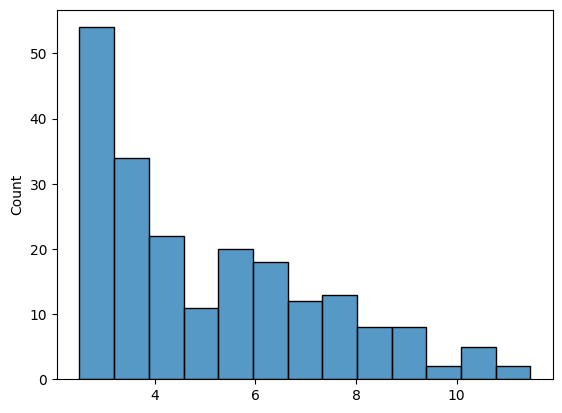

In [58]:
energy_bwdt = 0.70
sn.histplot(energy, binwidth=energy_bwdt)